# Predicting Fradulent Job Postings Using Naive Bayes Classification
Class: ISDS 7070

Authors: Youssuf Elnoamany, Arielle Laurent, Leopold Marx, Christopher O’Brien, and Luke Willson

Data Source: https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction


Our goal for this project is to minimize the false postivive rate without having outstandingly high false negative rate. This would classify more observations as fake but it also minimizes the fraudulent observations that would be classifed as real.

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#for splitting
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

#text model
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

# Figures inline and set visualization style
%matplotlib inline
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Loading Data Set
Github only allows files less than 25mb so we had to split the dataset up in three parts and merge it back together in python.

In [2]:
#loading data
df_fj1 = pd.read_csv("https://github.com/leopoldmarx/MyFiles/raw/master/fake_job_postings1.csv")
df_fj2 = pd.read_csv("https://github.com/leopoldmarx/MyFiles/raw/master/fake_job_postings2.csv")
df_fj3 = pd.read_csv("https://github.com/leopoldmarx/MyFiles/raw/master/fake_job_postings3.csv")
df_fj = pd.concat([df_fj1,df_fj2,df_fj3]).reset_index(drop=True) #Added this to fix the index COB
df_fj.set_index('job_id',inplace=True)
#looking at data
df_fj.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Descriptve stats of raw data

In [3]:
df_fj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17875 non-null  object
 6   requirements         15185 non-null  object
 7   benefits             10670 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

In [4]:
df_fj.fraudulent.value_counts()
#Naive Rule = 1-(866/17014) = 0.9491

0    17014
1      866
Name: fraudulent, dtype: int64

# Variable Understanding
This section is to understand if null variable values are discriminatory for predicting if the job listing is fraudlent or not. Some variables discriminate but we cannot use numeric values in the Naive Bayes model.

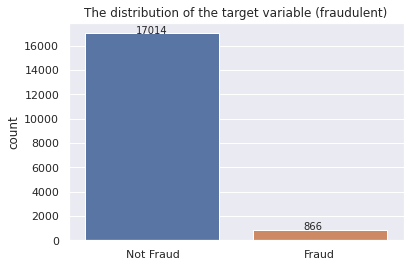

In [5]:
#Y variable distrubution 
ax= sns.countplot('fraudulent', data=df_fj)
plt.title('The distribution of the target variable (fraudulent)')

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.3, p.get_height()))


plt.xticks([0, 1],["Not Fraud",'Fraud'])
plt.xlabel("")

plt.show()

In [6]:
#This function can be called to help show percentages on bar graphs
def with_hue(plot, feature, Number_of_categories, hue_categories,):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.xticks([0, 1],["Not Fraud",'Fraud'])  
    plt.xlabel("")      
    plt.show()

## Function_null

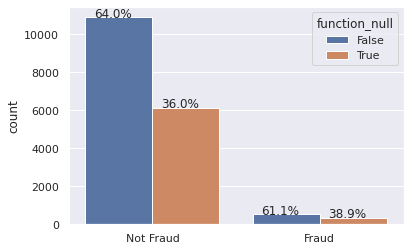

In [7]:
df_fj['function_null'] = df_fj['function'].isnull()
ax= sns.countplot('fraudulent', hue= 'function_null', data=df_fj)

with_hue(ax, df_fj.fraudulent,2,2)


## Industry_null

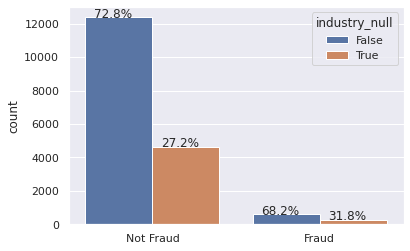

In [8]:
df_fj['industry_null'] = df_fj['industry'].isnull()
ax= sns.countplot('fraudulent', hue= 'industry_null', data=df_fj)
with_hue(ax, df_fj.fraudulent,2,2)


## Edu_null

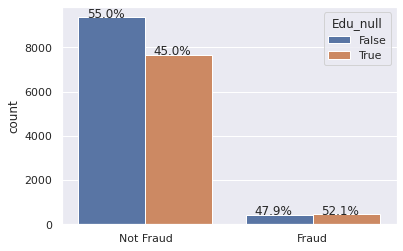

In [9]:
df_fj['Edu_null'] = df_fj['required_education'].isnull()
ax= sns.countplot('fraudulent', hue= 'Edu_null', data=df_fj)
with_hue(ax, df_fj.fraudulent,2,2)


## Exp_null

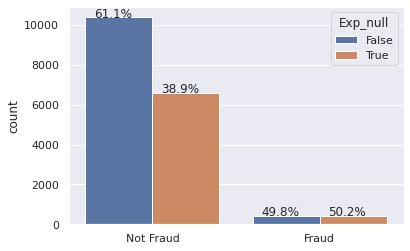

In [10]:
df_fj['Exp_null'] = df_fj['required_experience'].isnull()
ax= sns.countplot('fraudulent', hue= 'Exp_null', data=df_fj)
with_hue(ax, df_fj.fraudulent,2,2)


## Emp_null

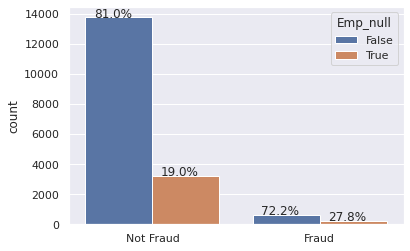

In [11]:
df_fj['Emp_null'] = df_fj['employment_type'].isnull()
ax= sns.countplot('fraudulent', hue= 'Emp_null', data=df_fj)
with_hue(ax, df_fj.fraudulent,2,2)


## Bene_null

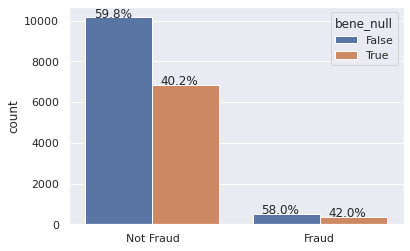

In [12]:
df_fj['bene_null'] = df_fj['benefits'].isnull()
ax= sns.countplot('fraudulent', hue= 'bene_null', data=df_fj)
with_hue(ax, df_fj.fraudulent,2,2)


## Comp_prof_null

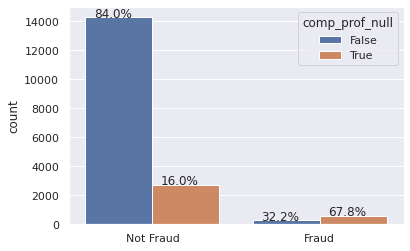

In [13]:
df_fj['comp_prof_null'] = df_fj['company_profile'].isnull()
ax= sns.countplot('fraudulent', hue= 'comp_prof_null', data=df_fj)
with_hue(ax, df_fj.fraudulent,2,2)


## Dept_null

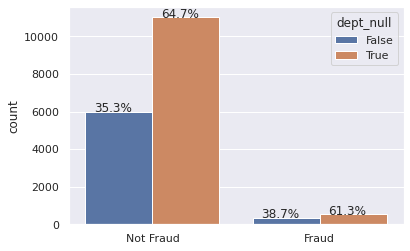

In [14]:
df_fj['dept_null'] = df_fj['department'].isnull()
ax= sns.countplot('fraudulent', hue= 'dept_null', data=df_fj)
with_hue(ax, df_fj.fraudulent,2,2)


## Salary_null

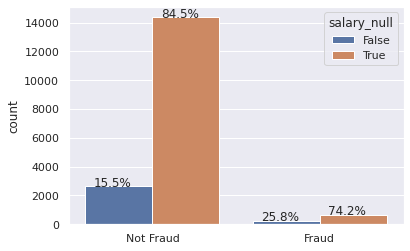

In [15]:
df_fj['salary_null'] = df_fj['salary_range'].isnull()
ax= sns.countplot('fraudulent', hue= 'salary_null', data=df_fj)
with_hue(ax, df_fj.fraudulent,2,2)


# Changing NaNs
We replaced NaNs with spaces to make it compatible with out `text` dummy variable

In [16]:
#replaced NaNs with blank spaces
df_fj.fillna(" ",inplace = True)

In [17]:
#checking new data
df_fj.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,function_null,industry_null,Edu_null,Exp_null,Emp_null,bene_null,comp_prof_null,dept_null,salary_null
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,False,True,True,False,False,True,False,False,True
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,False,False,True,False,False,False,False,False,True
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,True,True,True,True,True,True,False,True,True
4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,False,False,False,False,False,False,False,False,True
5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,False,False,False,False,False,False,False,True,True


## Combining Text Columns and Cleaning the Data

In [18]:
# combining all text data into one column
df_fj['text'] = df_fj['title'] + ' ' + df_fj['location'] + ' ' + df_fj['department'] + ' ' + df_fj['company_profile'] + ' ' + df_fj['description'] + ' ' + df_fj['requirements'] + ' ' + df_fj['benefits'] + ' ' + df_fj['employment_type'] + ' ' + df_fj['required_education']+'' +df_fj['required_experience'] +' ' + df_fj['industry'] + ' ' + df_fj['function'] 

In [19]:
df_fj.text.head(1)

job_id
1    Marketing Intern US, NY, New York Marketing We...
Name: text, dtype: object

In [20]:
#cleans text by removing HTML tags, punctiation, and numbers
def preprocess(text):
    clean_data = []
    for x in text: #this is Df_pd for Df_np (text[:])
        new_text = re.sub('<.*?>', '', x)   # remove HTML tags
        new_text = re.sub(r'[^\w\s]', '', new_text) # remove punc.
        new_text = re.sub(r'\d+','',new_text)# remove numbers         
        if new_text != '':
            clean_data.append(new_text)
    
    return clean_data
    

In [21]:
#tokenizes clean data
def tokenization_w(words):
    w_new = []
    for w in (words):  # for NumPy = words[:]
        
        w_token = word_tokenize(w)
        if w_token != '':
            w_new.append(w_token)
    return w_new

In [22]:
#Stemming to normalize parts of text data
snowball = SnowballStemmer(language = 'english')
def stemming(words):
    new = []
    for observation in words:
      stem_words = [snowball.stem(x) for x in observation]
      new.append(stem_words)
    return new

In [23]:
df_fj['text_clean_nostem'] = tokenization_w(preprocess(df_fj['text']))
df_fj['text_clean'] = stemming(df_fj['text_clean_nostem'])

#changes list for words to sting
df_fj['text_clean_nostem'] = [" ".join(i) for i in df_fj['text_clean_nostem']]
df_fj['text_clean'] = [" ".join(i) for i in df_fj['text_clean']]

# Modeling

## Test_Train_Split with Oversampling
Oversamling was done because there is a minimal amout of fraudlent cases. We settled on 10 times the amount of fraudlent cases to make the target variable percetage fake closer to 50/50. 

We investigated oversampling to create a near 50/50 split of real and fake job postings (19 times oversampling fake) but it did not impove the hitrate.


In [24]:
#Splits the full original dataframe
x_train_under, X_test, y_train_under, y_test = train_test_split(df_fj.drop('fraudulent', 1), df_fj.fraudulent, test_size=0.3, random_state=9)
#re-combines the X and Y for the training data to prepare for oversampling.  618 fakes
xy_train_under = pd.concat([x_train_under] + [y_train_under], axis=1).reset_index(drop=True)
#oversamples the training data by 9x. 6180 fakes. 
xy_train_under_fake = xy_train_under[xy_train_under.fraudulent == 1]
xy_train = pd.concat([xy_train_under] + [xy_train_under_fake] * 9, axis=0).reset_index(drop=True)
#drops the Y to make the oversampled X_train
X_train = xy_train.drop('fraudulent', 1)
#Oversampled y_train as a series to match the y_test series format
y_train = xy_train['fraudulent']

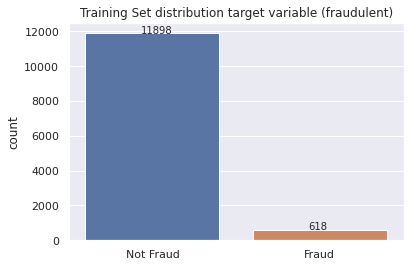

In [25]:
#Plot of real/fake split
ax = sns.countplot(y_train_under)
plt.title('Training Set distribution target variable (fraudulent)')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))
plt.xticks([0, 1],["Not Fraud",'Fraud'])
plt.xlabel("")
plt.show()

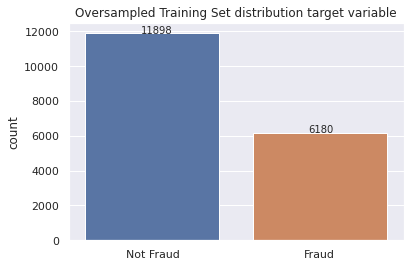

In [26]:
#Plot of new training split count
ax = sns.countplot(y_train)
plt.title('Oversampled Training Set distribution target variable')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))
plt.xticks([0, 1],["Not Fraud",'Fraud'])
plt.xlabel("")
plt.show()

## Text Model on Original Data Set (Unclean, not Oversampled)

In [27]:
# Created bag-of-word vectors
#Added ['text'] on the transform lines becasue the new X_train has all the columns except Y.
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(x_train_under['text'])
count_test = count_vectorizer.transform(X_test['text'])

In [28]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train_under)

#Training hitrate
fit = nb_classifier.predict(count_train)

# Create the predicted tags: pred
pred_og = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score_train = metrics.accuracy_score(y_train_under, fit)
score = metrics.accuracy_score(y_test, pred_og)

# Calculate the confusion matrix: cm
print('Training Hitrate:')
print(score_train)
cm_train = metrics.confusion_matrix(y_train_under, fit)
print(cm_train)
print(" ")
print('Validation Hitrate:')
print(score)
cm = metrics.confusion_matrix(y_test, pred_og)
print(cm)

Training Hitrate:
0.977788430808565
[[11803    95]
 [  183   435]]
 
Validation Hitrate:
0.9750186428038777
[[5096   20]
 [ 114  134]]


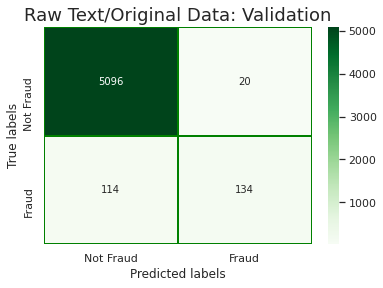

In [29]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap = 'Greens', fmt ='d', linewidths= 1, linecolor = 'green', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Raw Text/Original Data: Validation', fontsize=18); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

## Text Model with Oversampling


### Text Model with oversampling without clean data

In [30]:
# Created bag-of-word vectors
#Added ['text'] on the transform lines becasue the new X_train has all the columns except Y.
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train['text'])
count_test = count_vectorizer.transform(X_test['text'])

In [31]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

#Training hitrate
fit = nb_classifier.predict(count_train)

# Create the predicted tags: pred
pred_os = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score_train = metrics.accuracy_score(y_train, fit)
score = metrics.accuracy_score(y_test, pred_os)

# Calculate the confusion matrix: cm
print('Training Hitrate:')
print(score_train)
cm_train = metrics.confusion_matrix(y_train, fit)
print(cm_train)
print(" ")
print('Validation Hitrate:')
print(score)
cm = metrics.confusion_matrix(y_test, pred_os)
print(cm)

Training Hitrate:
0.974831286646753
[[11563   335]
 [  120  6060]]
 
Validation Hitrate:
0.9653243847874721
[[4960  156]
 [  30  218]]


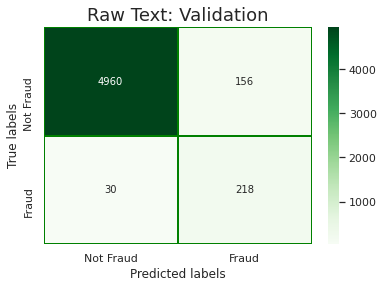

In [32]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap = 'Greens', fmt ='d', linewidths= 1, linecolor = 'green', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Raw Text: Validation', fontsize=18); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

### Text Model with Oversampling and Clean Data


In [33]:
# Created bag-of-word vectors
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train['text_clean'])
count_test = count_vectorizer.transform(X_test['text_clean'])

In [34]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

#Training hitrate
fit = nb_classifier.predict(count_train)

# Create the predicted tags: pred
pred_os_clean = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score_train = metrics.accuracy_score(y_train, fit)
score = metrics.accuracy_score(y_test, pred_os_clean)

# Calculate the confusion matrix: cm
print('Training Hitrate:')
print(score_train)
cm_train = metrics.confusion_matrix(y_train, fit)
print(cm_train)
print(" ")
print('Validation Hitrate:')
print(score)
cm = metrics.confusion_matrix(y_test, pred_os_clean)
print(cm)

Training Hitrate:
0.9761588671313198
[[11577   321]
 [  110  6070]]
 
Validation Hitrate:
0.9670022371364653
[[4974  142]
 [  35  213]]


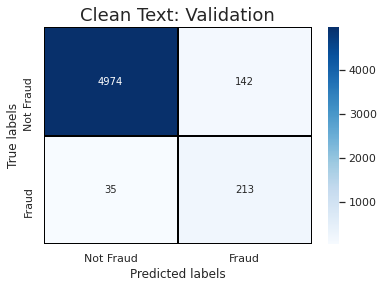

In [35]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap = 'Blues', fmt ='d', linewidths= 1, linecolor = 'black', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Clean Text: Validation', fontsize=18); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

### Text Model with Oversampling and Clean Data (No Stemming)

In [36]:
# Created bag-of-word vectors
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train['text_clean_nostem'])
count_test = count_vectorizer.transform(X_test['text_clean_nostem'])

In [37]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

#Training hitrate
fit = nb_classifier.predict(count_train)

# Create the predicted tags: pred
pred_os_clean_nostem = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score_train = metrics.accuracy_score(y_train, fit)
score = metrics.accuracy_score(y_test, pred_os_clean_nostem)

# Calculate the confusion matrix: cm
print('Training Hitrate:')
print(score_train)
cm_train = metrics.confusion_matrix(y_train, fit)
print(cm_train)
print(" ")
print('Validation Hitrate:')
print(score)
cm = metrics.confusion_matrix(y_test, pred_os_clean_nostem)
print(cm)

Training Hitrate:
0.9818010841907291
[[11659   239]
 [   90  6090]]
 
Validation Hitrate:
0.9729679343773303
[[5004  112]
 [  33  215]]


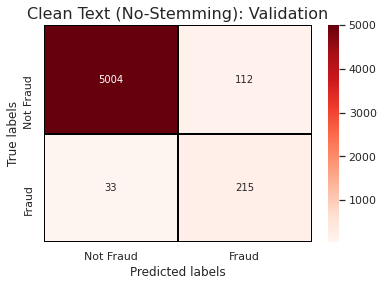

In [38]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap = 'Reds', fmt ='d', linewidths= 1, linecolor = 'black', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Clean Text (No-Stemming): Validation', fontsize=16); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

## Test_Train_Split with Undersampling
Undersampling was investigated for similar reasons to oversamping but instead of creating copies of fraudulent cases, we remove real cases to make it closer to a 50/50 split. 

This obviously removes data from the real job listings so we did not expect this model to preform as well as oversamling. 

In [39]:
#Splits the full original dataframe
x_train_under, X_test, y_train_under, y_test = train_test_split(df_fj.drop('fraudulent', 1), df_fj.fraudulent, test_size=0.3, random_state=9)
#re-combines the X and Y for the training data to prepare for undersampling.  618 fakes
xy_train_under = pd.concat([x_train_under] + [y_train_under], axis=1).reset_index(drop=True)
 
xy_train_under_fake = xy_train_under[xy_train_under.fraudulent == 1]
xy_train_under_real = xy_train_under[xy_train_under.fraudulent == 0]

# number of fake observations
n = len(xy_train_under_fake)

# samples same amount of real observations as the fake observations
xy_train_under_real_sample = xy_train_under_real.sample(n, random_state=38)

#combines sampled real and all fake observations
xy_train = pd.concat([xy_train_under_real_sample] + [xy_train_under_fake], axis=0).reset_index(drop=True)
#drops the Y to make the undersampled X_train
X_train = xy_train.drop('fraudulent', 1)
#undersampled y_train as a series to match the y_test series format
y_train = xy_train['fraudulent']

## Text Model with Undersampling


### Text Model with undersampling without clean data

In [40]:
# Created bag-of-word vectors
#Added ['text'] on the transform lines becasue the new X_train has all the columns except Y.
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train['text'])
count_test = count_vectorizer.transform(X_test['text'])

In [41]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

#Training hitrate
fit = nb_classifier.predict(count_train)

# Create the predicted tags: pred
pred_us = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score_train = metrics.accuracy_score(y_train, fit)
score = metrics.accuracy_score(y_test, pred_us)

# Calculate the confusion matrix: cm
print('Training Hitrate:')
print(score_train)
cm_train = metrics.confusion_matrix(y_train, fit)
print(cm_train)
print(" ")
print('Validation Hitrate:')
print(score)
cm = metrics.confusion_matrix(y_test, pred_us)
print(cm)

Training Hitrate:
0.9757281553398058
[[606  12]
 [ 18 600]]
 
Validation Hitrate:
0.8978374347501864
[[4592  524]
 [  24  224]]


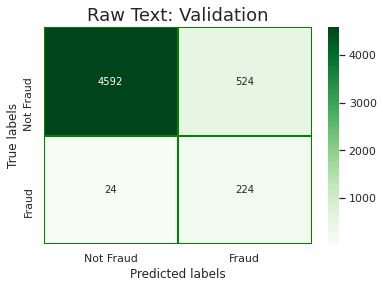

In [42]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap = 'Greens', fmt ='d', linewidths= 1, linecolor = 'green', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Raw Text: Validation', fontsize=18); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

### Text Model with Undersampling and Clean Data


In [43]:
# Created bag-of-word vectors
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train['text_clean'])
count_test = count_vectorizer.transform(X_test['text_clean'])

In [44]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

#Training hitrate
fit = nb_classifier.predict(count_train)

# Create the predicted tags: pred
pred_us_clean = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score_train = metrics.accuracy_score(y_train, fit)
score = metrics.accuracy_score(y_test, pred_us_clean)

# Calculate the confusion matrix: cm
print('Training Hitrate:')
print(score_train)
cm_train = metrics.confusion_matrix(y_train, fit)
print(cm_train)
print(" ")
print('Validation Hitrate:')
print(score)
cm = metrics.confusion_matrix(y_test, pred_us_clean)
print(cm)

Training Hitrate:
0.9733009708737864
[[604  14]
 [ 19 599]]
 
Validation Hitrate:
0.8976510067114094
[[4592  524]
 [  25  223]]


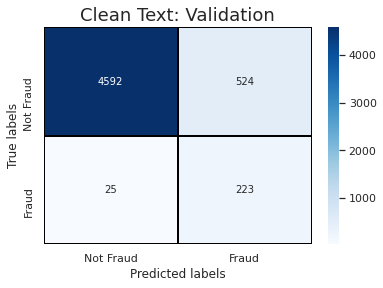

In [45]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap = 'Blues', fmt ='d', linewidths= 1, linecolor = 'black', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Clean Text: Validation', fontsize=18); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

### Text Model with Undersampling and Clean Data (No Stemming)

In [46]:
# Created bag-of-word vectors
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train['text_clean_nostem'])
count_test = count_vectorizer.transform(X_test['text_clean_nostem'])

In [47]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

#Training hitrate
fit = nb_classifier.predict(count_train)

# Create the predicted tags: pred
pred_us_clean_nostem = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score_train = metrics.accuracy_score(y_train, fit)
score = metrics.accuracy_score(y_test, pred_us_clean_nostem)

# Calculate the confusion matrix: cm
print('Training Hitrate:')
print(score_train)
cm_train = metrics.confusion_matrix(y_train, fit)
print(cm_train)
print(" ")
print('Validation Hitrate:')
print(score)
cm = metrics.confusion_matrix(y_test, pred_us_clean_nostem)
print(cm)

Training Hitrate:
0.9789644012944984
[[608  10]
 [ 16 602]]
 
Validation Hitrate:
0.9136838180462341
[[4677  439]
 [  24  224]]


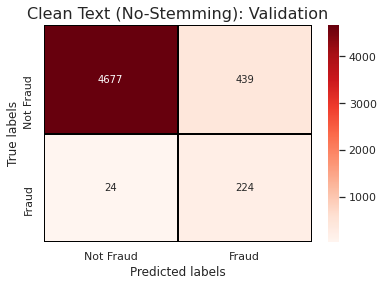

In [48]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap = 'Reds', fmt ='d', linewidths= 1, linecolor = 'black', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Clean Text (No-Stemming): Validation', fontsize=16); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

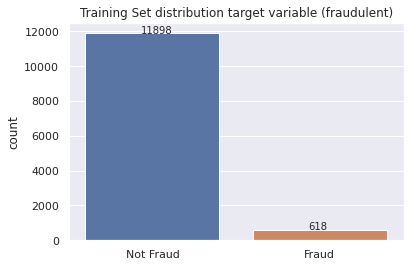

In [49]:
#Plot of real/fake split
ax = sns.countplot(y_train_under)
plt.title('Training Set distribution target variable (fraudulent)')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))
plt.xticks([0, 1],["Not Fraud",'Fraud'])
plt.xlabel("")
plt.show()

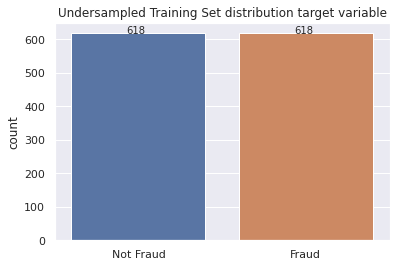

In [50]:
#Plot of new training split count
ax = sns.countplot(y_train)
plt.title('Undersampled Training Set distribution target variable')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))
plt.xticks([0, 1],["Not Fraud",'Fraud'])
plt.xlabel("")
plt.show()

# Resluts

## ROC Curves

Generate ROC curves

In [51]:
fpr_og, tpr_og,u = metrics.roc_curve(y_test, pred_og)
fpr_os, tpr_os,u = metrics.roc_curve(y_test, pred_os)
fpr_os_clean, tpr_os_clean,u = metrics.roc_curve(y_test, pred_os_clean)
fpr_os_clean_nostem, tpr_os_clean_nostem,u = metrics.roc_curve(y_test, pred_os_clean_nostem)
fpr_us, tpr_us,u = metrics.roc_curve(y_test, pred_us)
fpr_us_clean, tpr_us_clean,u = metrics.roc_curve(y_test, pred_us_clean)
fpr_us_clean_nostem, tpr_us_clean_nostem,u = metrics.roc_curve(y_test, pred_us_clean_nostem)

roc_auc_og = metrics.auc(fpr_og, tpr_og)
roc_auc_os = metrics.auc(fpr_os, tpr_os)
roc_auc_os_clean = metrics.auc(fpr_os_clean, tpr_os_clean)
roc_auc_os_clean_nostem = metrics.auc(fpr_os_clean_nostem, tpr_os_clean_nostem)
roc_auc_us = metrics.auc(fpr_us, tpr_us)
roc_auc_us_clean = metrics.auc(fpr_us_clean, tpr_us_clean)
roc_auc_us_clean_nostem = metrics.auc(fpr_us_clean_nostem, tpr_us_clean_nostem)

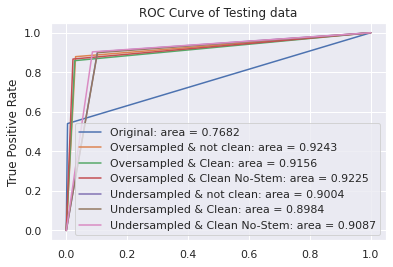

<Figure size 2160x1440 with 0 Axes>

In [52]:
plt.title("ROC Curve of Testing data") 

plt.plot(fpr_og,tpr_og, label = 'Original: area = %0.4f' % roc_auc_og)
plt.plot(fpr_os,tpr_os, label = 'Oversampled & not clean: area = %0.4f' % roc_auc_os)
plt.plot(fpr_os_clean,tpr_os_clean, label = 'Oversampled & Clean: area = %0.4f' % roc_auc_os_clean)
plt.plot(fpr_os_clean_nostem,tpr_os_clean_nostem, label = 'Oversampled & Clean No-Stem: area = %0.4f' % roc_auc_os_clean_nostem)
plt.plot(fpr_us,tpr_us, label = 'Undersampled & not clean: area = %0.4f' % roc_auc_us)
plt.plot(fpr_us_clean,tpr_us_clean, label = 'Undersampled & Clean: area = %0.4f' % roc_auc_us_clean)
plt.plot(fpr_us_clean_nostem,tpr_us_clean_nostem, label = 'Undersampled & Clean No-Stem: area = %0.4f' % roc_auc_us_clean_nostem)

plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.figure(figsize=(30,20))
plt.tight_layout()
plt.savefig('plot.png', dpi=600, bbox_inches='tight')
plt.show()